<a href="https://colab.research.google.com/github/kavithachitriki/OCRProject/blob/main/KerasRetinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
!git clone https://github.com/fizyr/keras-retinanet

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#https://drive.google.com/drive/folders/12a6KHwcQfIkrKRkQtEtnGjjKZ5ja25-8?usp=sharing

Mounted at /content/drive


In [4]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168000 sha256=5a2489b197285f54daa5ad022d696be108ca68e3f80c4aa9300a322ee8ca2f1f
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 1.0.0
    Uninstalling keras-retinanet-1.0.0:
      Successfully uninstalled keras-retinanet-1.0.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ocr_retinanet_model.h5 to ocr_retinanet_model.h5


In [5]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [6]:
!pip install gdown
!pip install tensorflow.gpu

     |████████████████████████████████| 394.3MB 43kB/s 


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr,preprocess_image,resize_image
from keras_retinanet.utils.visualization import draw_box,draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [8]:
register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)

rcParams['figure.figsize'] = 22,10

RANDOM_SEED=42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
os.makedirs("snapshots",exist_ok=True)

In [10]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:01, 188MB/s]


In [11]:
df = pd.read_csv('labels.csv')

dataset=dict()
dataset["image_name"]=list()
dataset["x_min"]=list()
dataset["y_min"]=list()
dataset["x_max"]=list()
dataset["y_max"]=list()
dataset["class_name"]=list()

width=1
height=1
counter=1

from csv import reader
# open file in read mode
with open('labels.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        # row variable is a list that represents a row in csv
        dataset["class_name"].append(row[0])
        img=Image.open(row[5]).convert('RGB')
        img.save(f'pantest{counter}.jpeg','JPEG')
        dataset["image_name"].append(f'pantest{counter}.jpeg')
        counter=counter+1
        x_min=int(row[1])
        y_min=int(row[2])
        x_max=int(row[1])+int(row[3])
        y_max=int(row[2])+int(row[4])
        dataset["x_min"].append( x_min* width)
        dataset["y_min"].append( y_min* height)
        dataset["x_max"].append( x_max * width)
        dataset["y_max"].append( y_max * height)  





In [ ]:
print(dataset["image_name"])
  

['pantest1.jpeg', 'pantest2.jpeg', 'pantest3.jpeg', 'pantest4.jpeg', 'pantest5.jpeg', 'pantest6.jpeg', 'pantest7.jpeg', 'pantest8.jpeg', 'pantest9.jpeg', 'pantest10.jpeg', 'pantest11.jpeg', 'pantest12.jpeg', 'pantest13.jpeg', 'pantest14.jpeg', 'pantest15.jpeg', 'pantest16.jpeg', 'pantest17.jpeg']


In [12]:
df=pd.DataFrame(dataset)
df.head()

image_name  x_min  y_min  x_max  y_max  class_name
0  pantest1.jpeg    128    160    147    182  check_mark
1  pantest2.jpeg    164    256    181    273  check_mark
2  pantest3.jpeg    152    235    172    253  check_mark
3  pantest4.jpeg    175    241    193    259  check_mark
4  pantest5.jpeg    139    246    158    263  check_mark

In [13]:
def show_image_objects(image_row):
  img_path = image_row.image_name
  print(image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max)
  box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]
  image = read_image_bgr(img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  draw_box(draw, box, color=(255, 255, 0))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

128 160 147 182


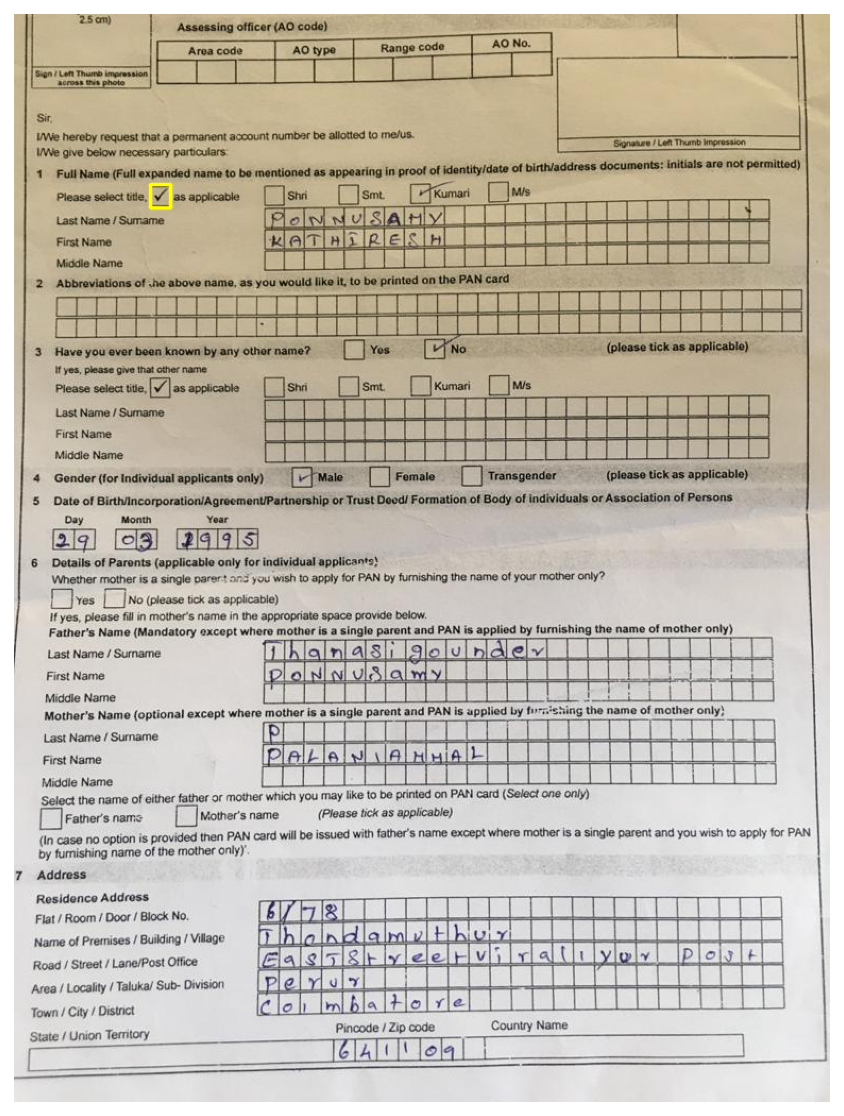

In [ ]:

show_image_objects(df.iloc[0])



In [14]:
train_df,test_df=train_test_split(df,test_size=0.2,random_state=RANDOM_SEED)

In [ ]:
train_df.head()

image_name  x_min  y_min  x_max  y_max  class_name
183  pantest184.jpeg    175    241    193    259  check_mark
38    pantest39.jpeg     96    236    121    255  check_mark
24    pantest25.jpeg    183    265    200    283  check_mark
142  pantest143.jpeg    143    244    166    264  check_mark
141  pantest142.jpeg    151    233    173    250  check_mark

In [ ]:
test_df.head()

image_name  x_min  y_min  x_max  y_max  class_name
82    pantest83.jpeg    164    256    181    273  check_mark
15    pantest16.jpeg    172    243    191    261  check_mark
111  pantest112.jpeg    138    233    162    250  check_mark
177  pantest178.jpeg    138    233    162    250  check_mark
76    pantest77.jpeg    143    244    166    264  check_mark

In [15]:
ANNOTATIONS_FILE="annotations.csv"
CLASSES_FILE="classes.csv"

In [17]:
train_df.to_csv(ANNOTATIONS_FILE,index=False,header=None)

In [16]:
classes=set(['check_mark'])

with open(CLASSES_FILE,'w') as f:
  for i,line in enumerate(sorted(classes)):
    f.write('{}, {}\n'.format(line,i))

In [18]:
!head annotations.csv

pantest184.jpeg,175,241,193,259,check_mark
pantest39.jpeg,96,236,121,255,check_mark
pantest25.jpeg,183,265,200,283,check_mark
pantest143.jpeg,143,244,166,264,check_mark
pantest142.jpeg,151,233,173,250,check_mark
pantest30.jpeg,138,233,162,250,check_mark
pantest20.jpeg,175,241,193,259,check_mark
pantest170.jpeg,158,228,178,247,check_mark
pantest128.jpeg,138,233,162,250,check_mark
pantest119.jpeg,139,246,158,263,check_mark


In [19]:
!head classes.csv

check_mark, 0


In [20]:
#Training
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [ ]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --lr 1e-3 --batch-size 8 --steps 10 --epochs 10 csv annotations.csv classes.csv

2021-03-26 08:35:40.095484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Creating model, this may take a second...
2021-03-26 08:35:42.248402: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-26 08:35:42.249438: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-26 08:35:42.260923: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-26 08:35:42.260990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cedc3c4d1fac): /proc/driver/nvidia/version does not exist
2021-03-26 08:35:42.261525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

In [21]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_10.h5


In [22]:
model_path=os.path.join('snapshots',sorted(os.listdir('snapshots'),reverse=True)[0])

In [23]:
model_path

'snapshots/resnet50_csv_10.h5'

In [24]:
model=models.load_model(model_path,backbone_name='resnet50')

In [25]:
model=models.convert_model(model)

In [26]:
labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

In [27]:
labels_to_names

{0: 'check_mark'}

In [28]:
THRES_SCORE = 0.5
def show_detected_objects(image_row):
  img_path = image_row.image_name
  true_box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]
  image = read_image_bgr(img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  image=preprocess_image(image)
  image,scale=resize_image(image)
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image,axis=0))
  boxes=boxes/scale
  draw_box(draw, true_box, color=(218, 45, 45))
  #draw detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
       break
    color = label_color(label)
    b = box.astype(int)
    draw_box(image, b, color=color)
    print("box drawn")
    caption = "{}{:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)
    print("object detected")
    print(b[0])
    print(b[1])
    print(b[2])
    print(b[3])
    d_box = [b[0], b[1], b[2],b[3]]
    draw_box(draw, d_box, color=(255, 255, 0))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    return d_box
  #plt.figure(figsize=(15, 15))
  




In [ ]:
test_df.head()

image_name  x_min  y_min  x_max  y_max  class_name
82    pantest83.jpeg    164    256    181    273  check_mark
15    pantest16.jpeg    172    243    191    261  check_mark
111  pantest112.jpeg    138    233    162    250  check_mark
177  pantest178.jpeg    138    233    162    250  check_mark
76    pantest77.jpeg    143    244    166    264  check_mark

box drawn
object detected
265
840
514
911


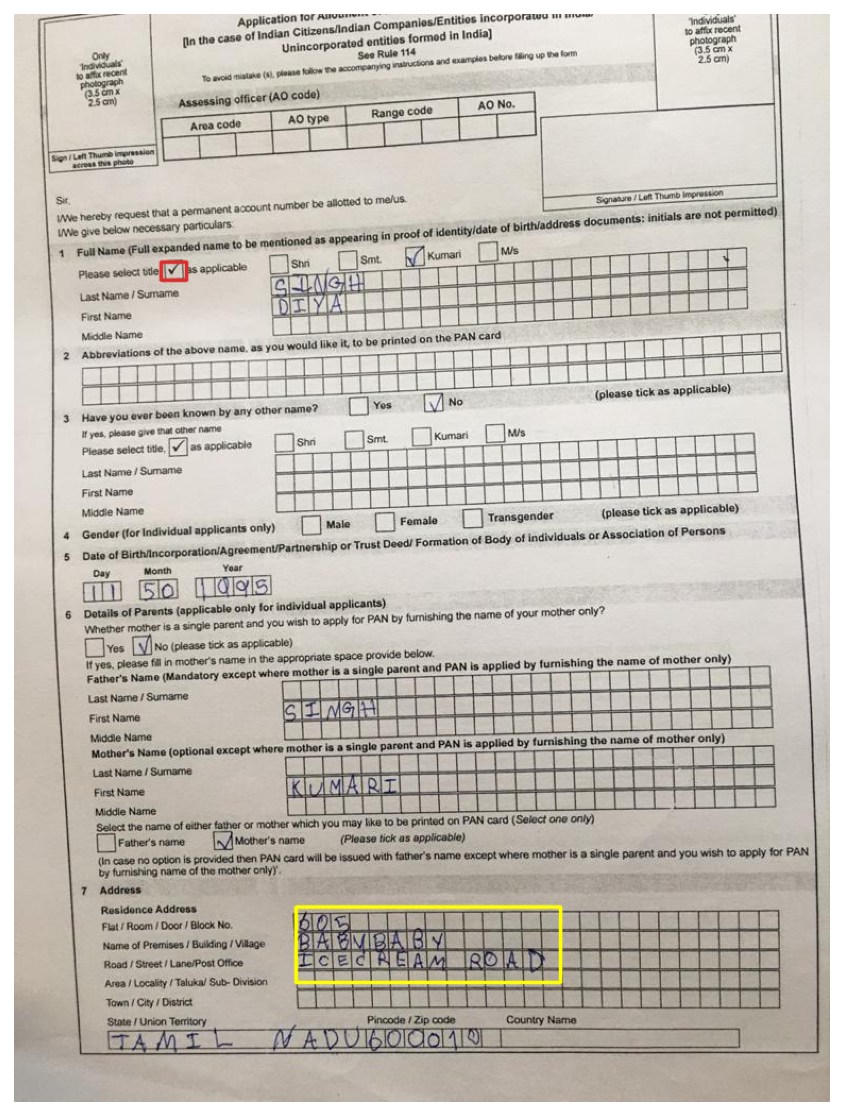

In [31]:
testimage=test_df.iloc[3]
x_check_min,y_check_min,x_check_max,y_check_max=show_detected_objects(testimage)
  

In [ ]:
#Saving model in h5 format
saved_model=model.save("ocr_retinanet_model.h5")

In [36]:
reconstructed_model=models.load_model("ocr_retinanet_model.h5",backbone_name='resnet50')

In [32]:
import cv2
from google.colab.patches import cv2_imshow
import imutils

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def get_letters(img):
    letters = []
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        # ypred = model.predict(thresh)
        #ypred = LB.inverse_transform(ypred)
        #[x] = ypred
        #letters.append(x)
        cv2_imshow(image)
    return image




In [33]:
import numpy as np
import pandas as pd
import cv2
import imutils
from google.colab.patches import cv2_imshow
from keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
panimg=cv2.imread('pan13.jpeg')
emnist_model = load_model('emnist_trained.h5')
mapp = pd.read_csv(
    r'emnist-letters-mapping.txt',
    delimiter=' ',
    index_col=0,
    header=None,
    squeeze=True
)
string_list = [chr(i) for i in mapp[1].values]
string_list
mapp['String'] = string_list
mapp


1    2 String
0                 
1   65   97      A
2   66   98      B
3   67   99      C
4   68  100      D
5   69  101      E
6   70  102      F
7   71  103      G
8   72  104      H
9   73  105      I
10  74  106      J
11  75  107      K
12  76  108      L
13  77  109      M
14  78  110      N
15  79  111      O
16  80  112      P
17  81  113      Q
18  82  114      R
19  83  115      S
20  84  116      T
21  85  117      U
22  86  118      V
23  87  119      W
24  88  120      X
25  89  121      Y
26  90  122      Z

In [74]:
THRES_SCORE = 0.4
def model_detected_objects(image):
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  image=preprocess_image(image)
  image,scale=resize_image(image)
  boxes, scores, labels = reconstructed_model.predict_on_batch(np.expand_dims(image,axis=0))
  boxes=boxes/scale
  #draw detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    print(score)
    if score < THRES_SCORE:
       break
    color = label_color(label)
    b = box.astype(int)
    draw_box(image, b, color=color)
    print("box drawn")
    caption = "{}{:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)
    print("object detected")
    print(b[0])
    print(b[1])
    print(b[2])
    print(b[3])
    d_box = [b[0], b[1], b[2],b[3]]
    draw_box(draw, d_box, color=(255, 255, 0))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    return d_box
  #plt.figure(figsize=(15, 15))
  




In [67]:
import cv2
import numpy as np
import imutils

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)



# Load image, grayscale, Otsu's threshold 

def get_letters_name(image):
  copy = image.copy()
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
  #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)
  kernel = np.ones((3, 3), np.uint8)
  imgMorph = cv2.erode(thresh, kernel, iterations = 1)
  contours, hierarchy = cv2.findContours(imgMorph,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  cnts=contours
  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  cnts = sort_contours(cnts, method="left-to-right")[0]

  letters=[]
  ROI_number = 0
  for c in cnts:
      if cv2.contourArea(c) < 100:
        continue
      print(cv2.contourArea(c))
      x,y,w,h = cv2.boundingRect(c)
      aspect_ratio = h/w
      if aspect_ratio < 0.4:
        continue
      ROI = thresh[y:y+h, x:x+w]
      cv2_imshow(ROI)
      roi1=cv2.rectangle(copy,(x,y),(x+w,y+h),(36,255,12),2)
      roi = cv2.resize(ROI, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
      roi = np.array(roi) 
      t = np.copy(roi)
      t = t / 255.0
      t = 1 - t
      t = t.reshape(1, 784)
      ypred = emnist_model.predict_classes(t)
      ypred=mapp['String'][ypred]
      [x] = ypred
      print(x)
      letters.append(x)
      cv2_imshow(thresh)
      cv2_imshow(copy)
      print(letters)






In [84]:
def predict_word(x1,y1,x2,y2,panimg):
  # get xmin,ymin,xmax,ymax of checkmark first
  x_check_min,y_check_min,x_check_max,y_check_max=model_detected_objects(panimg)
  anchorx1=x_check_min
  anchory1=y_check_min
  anchorx2=x_check_max
  anchory2=y_check_max
  fl_x_min=int(x_check_min)+(x1-anchorx1)
  fl_y_min=int(y_check_min)+(y1-anchory1)
  fl_x_max=int(x_check_max)+(x2-anchorx2)
  fl_y_max=int(y_check_max)+(y2-anchory2)
  fatherLastName = panimg[fl_y_min:fl_y_max, fl_x_min:fl_x_max]
  cv2_imshow(fatherLastName)
  get_letters_name(fatherLastName)


0.4049941
box drawn
object detected
125
161
150
182


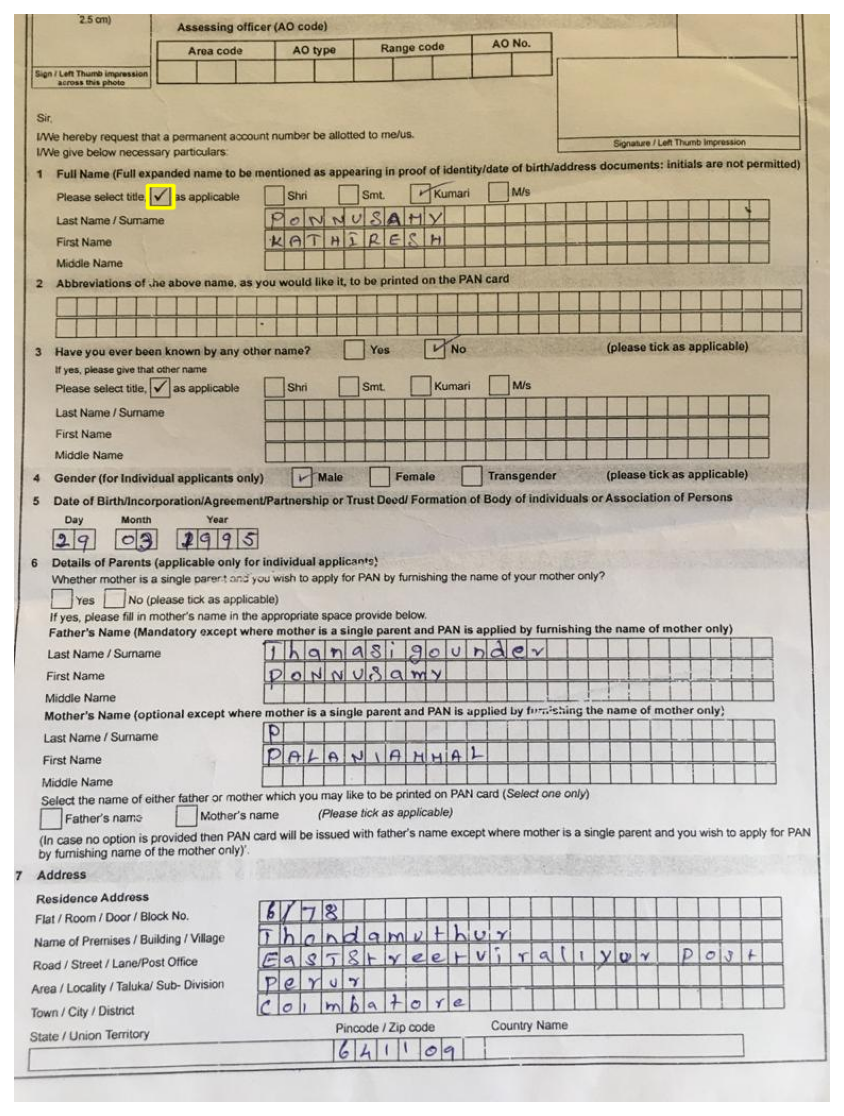

714.5
185.0


L


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


['L']
119.5


J


['L', 'J']
170.0


D


['L', 'J', 'D']
182.0


H


['L', 'J', 'D', 'H']
256.0


A


['L', 'J', 'D', 'H', 'A']
161.0


S


['L', 'J', 'D', 'H', 'A', 'S']
220.5


L


['L', 'J', 'D', 'H', 'A', 'S', 'L']
155.5


B


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B']
183.0


D


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D']
259.0


J


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J']
206.0


H


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H']
175.0


B


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B']
264.0


W


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W']
280.0


L


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L']
266.5


L


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L', 'L']
259.0


L


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L', 'L', 'L']
258.5


L


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L', 'L', 'L', 'L']
269.5


Y


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L', 'L', 'L', 'L', 'Y']
272.0


W


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L', 'L', 'L', 'L', 'Y', 'W']
267.0


L


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L', 'L', 'L', 'L', 'Y', 'W', 'L']
272.0


W


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L', 'L', 'L', 'L', 'Y', 'W', 'L', 'W']
326.0


L


['L', 'J', 'D', 'H', 'A', 'S', 'L', 'B', 'D', 'J', 'H', 'B', 'W', 'L', 'L', 'L', 'L', 'Y', 'W', 'L', 'W', 'L']


In [95]:
#Father Last Name
lastname_xmin=230
lastname_ymin=585
lastname_xmax=680
lastname_ymax=612

panimg=cv2.imread('pan3.jpeg')

predict_word(lastname_xmin,lastname_ymin,lastname_xmax,lastname_ymax,panimg)
            

0.5593261
box drawn
object detected
137
230
162
251


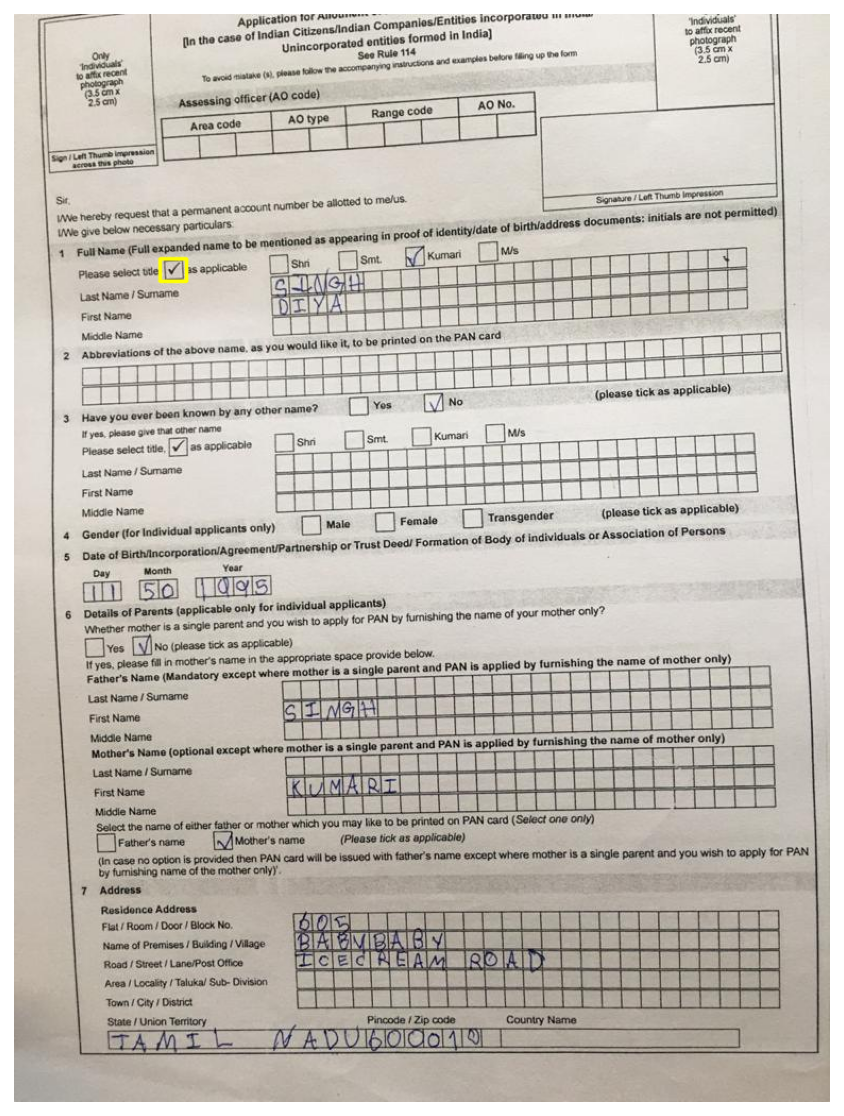

118.5


Q


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


['Q']
138.0


L


['Q', 'L']
193.5


K


['Q', 'L', 'K']
186.0


L


['Q', 'L', 'K', 'L']
165.0


W


['Q', 'L', 'K', 'L', 'W']
149.5


L


['Q', 'L', 'K', 'L', 'W', 'L']
135.0


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L']
108.0


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L']
115.5


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L']
126.5


J


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J']
141.0


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L']
153.5


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L']
174.0


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L']
197.0


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L']
221.5


Y


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L', 'Y']
240.5


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L', 'Y', 'L']
244.5


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L', 'Y', 'L', 'L']
233.5


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L', 'Y', 'L', 'L', 'L']
243.0


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L', 'Y', 'L', 'L', 'L', 'L']
228.0


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L', 'Y', 'L', 'L', 'L', 'L', 'L']
217.0


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L', 'Y', 'L', 'L', 'L', 'L', 'L', 'L']
199.5


L


['Q', 'L', 'K', 'L', 'W', 'L', 'L', 'L', 'L', 'J', 'L', 'L', 'L', 'L', 'Y', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


In [101]:
#First Name
firstname_xmin=243
firstname_ymin=245
firstname_xmax=677
firstname_ymax=265
panimg=cv2.imread('pan7.jpeg')
predict_word(firstname_xmin,firstname_ymin,firstname_xmax,firstname_ymax,panimg)


0.5593261
box drawn
object detected
137
230
162
251


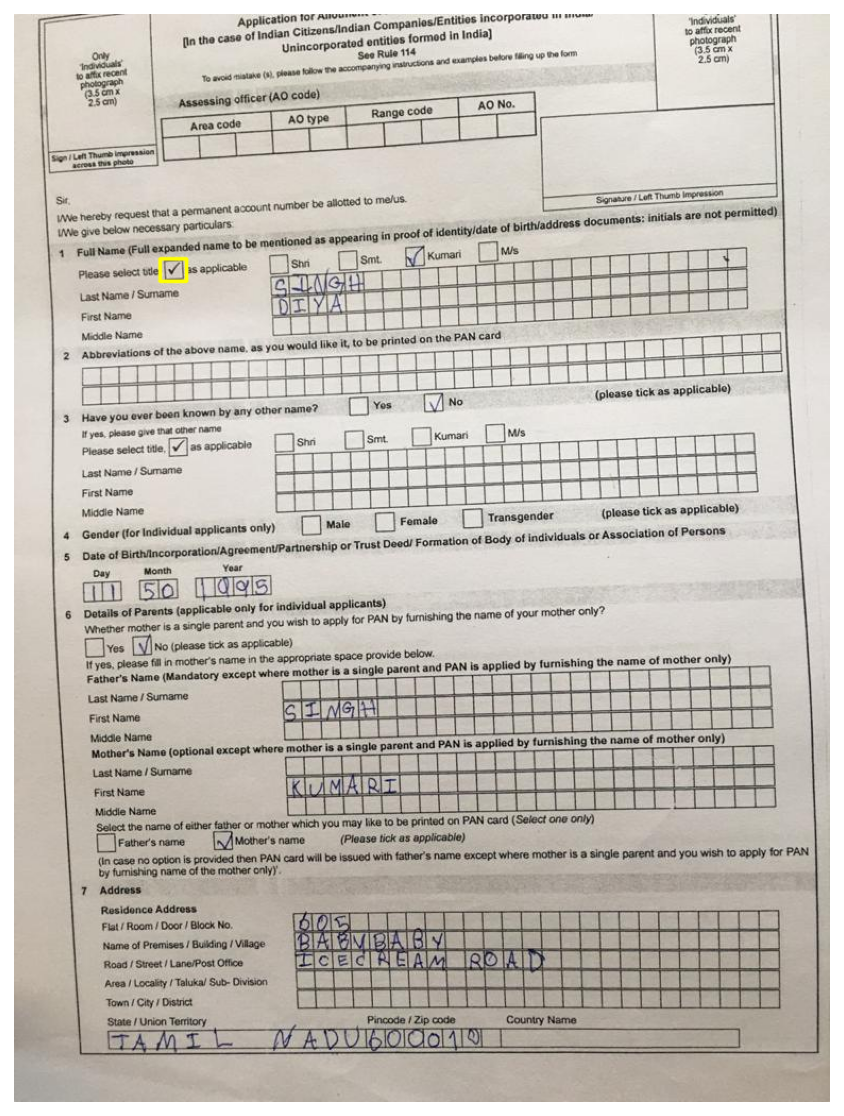

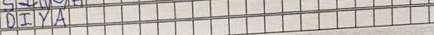

223.0


I


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


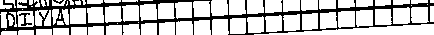

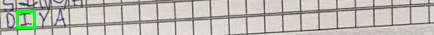

['I']
221.5


Y


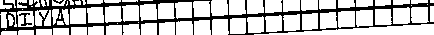

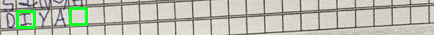

['I', 'Y']
105.0


W


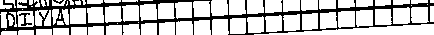

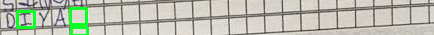

['I', 'Y', 'W']
219.5


L


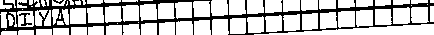

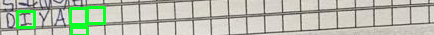

['I', 'Y', 'W', 'L']
115.5


L


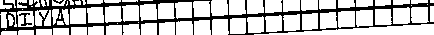

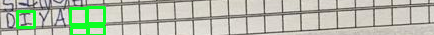

['I', 'Y', 'W', 'L', 'L']
225.5


L


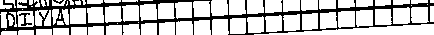

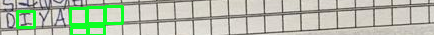

['I', 'Y', 'W', 'L', 'L', 'L']
132.5


L


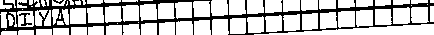

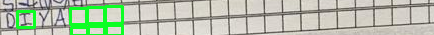

['I', 'Y', 'W', 'L', 'L', 'L', 'L']
224.5


L


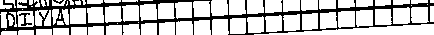

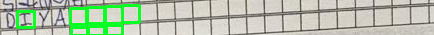

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L']
149.0


L


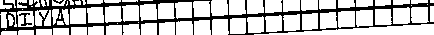

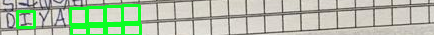

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L']
231.0


L


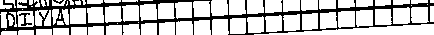

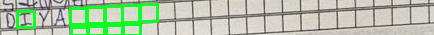

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
161.5


L


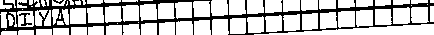

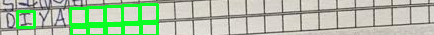

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
224.5


L


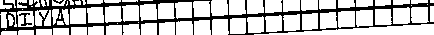

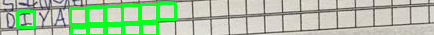

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
174.5


L


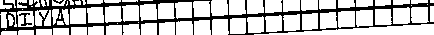

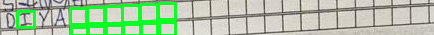

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
229.0


L


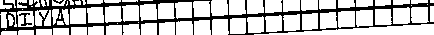

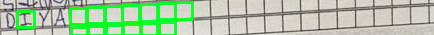

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
203.0


L


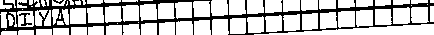

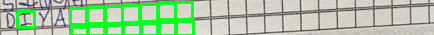

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
229.0


L


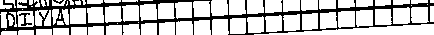

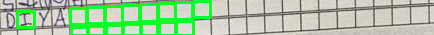

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
210.0


L


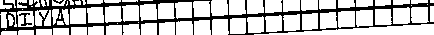

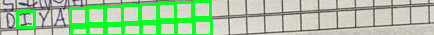

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
230.0


L


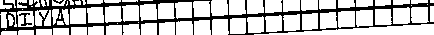

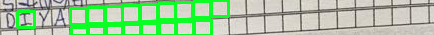

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
227.5


L


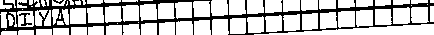

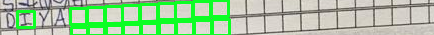

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
211.0


L


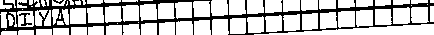

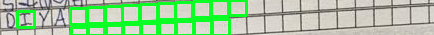

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
223.0


W


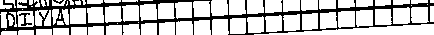

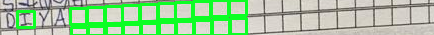

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W']
227.5


L


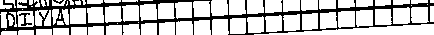

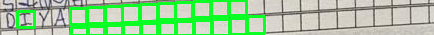

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L']
196.0


L


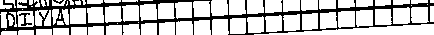

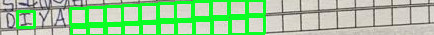

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L']
882.0
225.5


L


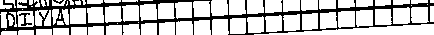

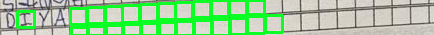

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L']
182.5


L


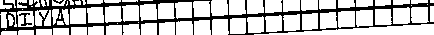

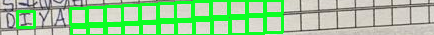

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L']
227.0


L


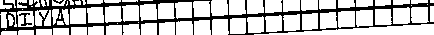

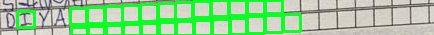

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L']
164.5


L


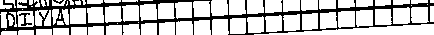

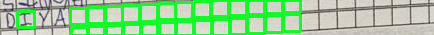

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L']
148.0


L


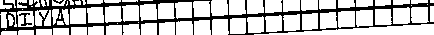

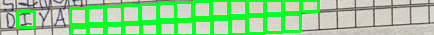

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
225.0


L


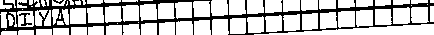

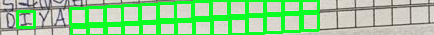

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
129.0


L


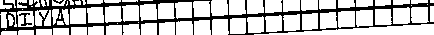

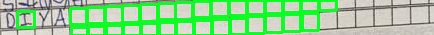

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
229.5


L


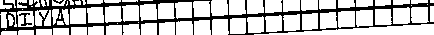

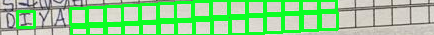

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
239.5


L


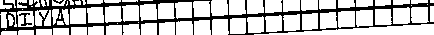

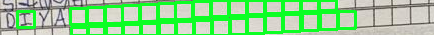

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
105.0


L


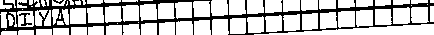

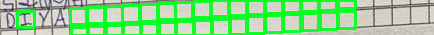

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
237.5


L


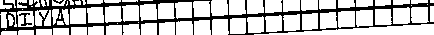

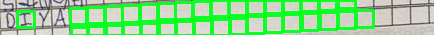

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
228.0


L


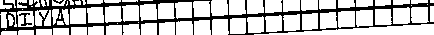

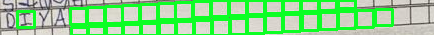

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
240.5


L


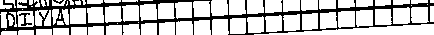

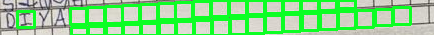

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
237.0


L


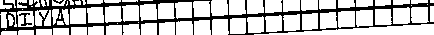

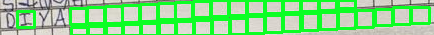

['I', 'Y', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'W', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


In [103]:
#Last Name
firstname_xmin=243
firstname_ymin=255
firstname_xmax=677
firstname_ymax=290
panimg=cv2.imread('pan7.jpeg')
predict_word(firstname_xmin,firstname_ymin,firstname_xmax,firstname_ymax,panimg)
            

# New Section